# Analysis final gaze processing HA


This code was developed and written by Jasmin L. Walter

In [40]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Preprocessing

## import

In [41]:
## optimizationimport copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
# import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

## optimization

In [42]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


## data paths & participant list

In [43]:
data_savepath_resampled = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step2_resampling"


data_savepath_intermediateP = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_savepath_intervals = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step3_gazeProcessing/intervals"
data_savepath_processed_gazes = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step3_gazeProcessing"

data_savepath_plots= "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/gaze_processing_plots"


# Getting the Folder without hidden files in ascending order 
# DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [44]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city - HumanA version with agents
PartList = [365, 1754, 2258, 2693, 3310, 4176, 4597, 4796, 4917, 5741, 6642, 7093, 7264, 7412, 7842, 8007, 8469, 8673, 9472, 9502, 9586, 9601]

print(len(PartList),'participants') 

22 participants



# Analysis

In [45]:
print('start')


gaze_lengths = pd.DataFrame()
saccade_lengths = pd.DataFrame()
noData_lengths = pd.DataFrame()


    
dataLength_overview = pd.DataFrame()



# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    gaze_durations = []
    saccade_durations = []
    noD_durations = []
    fix_NH_durations = []
    dataLength = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_processed_gazes) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))
            
            fix_length = data.loc[data['events'] == 2.0, 'length']
            sacc_length = data.loc[data['events'] == 1.0, 'length']
            noD_length =  data.loc[data['events'] == 3.0, 'length']
        
            
            gaze_durations.extend(fix_length)
            saccade_durations.extend(sacc_length)
            noD_durations.extend(noD_length)

            dataLength.append(len(data))  # Append to the list directly
    
    # Function to extend DataFrame with NaNs
    def extend_df(df, target_length):
        current_length = len(df)
        if current_length < target_length:
            additional_rows = target_length - current_length
            extra_df = pd.DataFrame({col: [float('nan')] * additional_rows for col in df.columns})
            df = pd.concat([df, extra_df], ignore_index=True)
        return df

    # Extend gaze_lengths DataFrame if necessary
    max_length_gaze = len(gaze_durations)
    gaze_lengths = extend_df(gaze_lengths, max_length_gaze)
    gaze_lengths[currentPart] = pd.Series(gaze_durations)

    # Extend saccade_lengths DataFrame if necessary
    max_length_saccade = len(saccade_durations)
    saccade_lengths = extend_df(saccade_lengths, max_length_saccade)
    saccade_lengths[currentPart] = pd.Series(saccade_durations)

    # Extend noData_lengths DataFrame if necessary
    max_length_noData = len(noD_durations)
    noData_lengths = extend_df(noData_lengths, max_length_noData)
    noData_lengths[currentPart] = pd.Series(noD_durations)

    # Extend dataLength_overview DataFrame if necessary
    max_length_dataLength = len(dataLength)
    dataLength_overview = extend_df(dataLength_overview, max_length_dataLength)
    dataLength_overview[currentPart] = pd.Series(dataLength)

    



            # file = "1004_Session_1_ET_1_data_processed_gazes.csv"
            # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


#             # Variables to store start times
#             gaze_start_time = None
#             saccade_start_time = None

#             # Iterate through the DataFrame to find start and end times
#             for index, row in data.iterrows():
#                 if row['events'] == 2.0:
#                     gaze_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -2.0 and gaze_start_time is not None:
#                     gaze_durations.append((row['timeStampDataPointStart_converted'] - gaze_start_time))
#                     gaze_start_time = None
#                 elif row['events'] == 1.0:
#                     saccade_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -1.0 and saccade_start_time is not None:
#                     saccade_durations.append((row['timeStampDataPointStart_converted'] - saccade_start_time))
#                     saccade_start_time = None# file and data length

start


📄 0 of 22 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 365


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_1_ET_1_data_processed_gazes.csv
process file  365_Session_1_ET_2_data_processed_gazes.csv
process file  365_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_2_ET_1_data_processed_gazes.csv
process file  365_Session_2_ET_2_data_processed_gazes.csv
process file  365_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_3_ET_1_data_processed_gazes.csv
process file  365_Session_3_ET_2_data_processed_gazes.csv
process file  365_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_4_ET_1_data_processed_gazes.csv
process file  365_Session_4_ET_2_data_processed_gazes.csv
process file  365_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_5_ET_1_data_processed_gazes.csv
process file  365_Session_5_ET_2_data_processed_gazes.csv
process file  365_Session_5_ET_3_data_processed_gazes.csv
Participant 1 - participant ID 1754


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_1_ET_1_data_processed_gazes.csv
process file  1754_Session_1_ET_2_data_processed_gazes.csv
process file  1754_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_2_ET_1_data_processed_gazes.csv
process file  1754_Session_2_ET_2_data_processed_gazes.csv
process file  1754_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_3_ET_1_data_processed_gazes.csv
process file  1754_Session_3_ET_2_data_processed_gazes.csv
process file  1754_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_4_ET_1_data_processed_gazes.csv
process file  1754_Session_4_ET_2_data_processed_gazes.csv
process file  1754_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_5_ET_1_data_processed_gazes.csv
process file  1754_Session_5_ET_2_data_processed_gazes.csv
process file  1754_Session_5_ET_3_data_processed_gazes.csv
Participant 2 - participant ID 2258


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_1_ET_1_data_processed_gazes.csv
process file  2258_Session_1_ET_2_data_processed_gazes.csv
process file  2258_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_2_ET_1_data_processed_gazes.csv
process file  2258_Session_2_ET_2_data_processed_gazes.csv
process file  2258_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_3_ET_1_data_processed_gazes.csv
process file  2258_Session_3_ET_2_data_processed_gazes.csv
process file  2258_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_4_ET_1_data_processed_gazes.csv
process file  2258_Session_4_ET_2_data_processed_gazes.csv
process file  2258_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_5_ET_1_data_processed_gazes.csv
process file  2258_Session_5_ET_2_data_processed_gazes.csv
process file  2258_Session_5_ET_3_data_processed_gazes.csv
Participant 3 - participant ID 2693


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_1_ET_1_data_processed_gazes.csv
process file  2693_Session_1_ET_2_data_processed_gazes.csv
process file  2693_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_2_ET_1_data_processed_gazes.csv
process file  2693_Session_2_ET_2_data_processed_gazes.csv
process file  2693_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_3_ET_1_data_processed_gazes.csv
process file  2693_Session_3_ET_2_data_processed_gazes.csv
process file  2693_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_4_ET_1_data_processed_gazes.csv
process file  2693_Session_4_ET_2_data_processed_gazes.csv
process file  2693_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_5_ET_1_data_processed_gazes.csv
process file  2693_Session_5_ET_2_data_processed_gazes.csv
process file  2693_Session_5_ET_3_data_processed_gazes.csv
Participant 4 - participant ID 3310


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_1_ET_1_data_processed_gazes.csv
process file  3310_Session_1_ET_2_data_processed_gazes.csv
process file  3310_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_2_ET_1_data_processed_gazes.csv
process file  3310_Session_2_ET_2_data_processed_gazes.csv
process file  3310_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_3_ET_1_data_processed_gazes.csv
process file  3310_Session_3_ET_2_data_processed_gazes.csv
process file  3310_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_4_ET_1_data_processed_gazes.csv
process file  3310_Session_4_ET_2_data_processed_gazes.csv
process file  3310_Session_4_ET_3_data_processed_gazes.csv
process file  3310_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_5_ET_1_data_processed_gazes.csv
process file  3310_Session_5_ET_2_data_processed_gazes.csv
process file  3310_Session_5_ET_3_data_processed_gazes.csv
Participant 5 - participant ID 4176


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_1_ET_1_data_processed_gazes.csv
process file  4176_Session_1_ET_2_data_processed_gazes.csv
process file  4176_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_2_ET_1_data_processed_gazes.csv
process file  4176_Session_2_ET_2_data_processed_gazes.csv
process file  4176_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_3_ET_1_data_processed_gazes.csv
process file  4176_Session_3_ET_2_data_processed_gazes.csv
process file  4176_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_4_ET_1_data_processed_gazes.csv
process file  4176_Session_4_ET_2_data_processed_gazes.csv
process file  4176_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_5_ET_1_data_processed_gazes.csv
process file  4176_Session_5_ET_2_data_processed_gazes.csv
process file  4176_Session_5_ET_3_data_processed_gazes.csv
Participant 6 - participant ID 4597


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_1_ET_1_data_processed_gazes.csv
process file  4597_Session_1_ET_2_data_processed_gazes.csv
process file  4597_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_2_ET_1_data_processed_gazes.csv
process file  4597_Session_2_ET_2_data_processed_gazes.csv
process file  4597_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_3_ET_1_data_processed_gazes.csv
process file  4597_Session_3_ET_2_data_processed_gazes.csv
process file  4597_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_4_ET_1_data_processed_gazes.csv
process file  4597_Session_4_ET_2_data_processed_gazes.csv
process file  4597_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_5_ET_1_data_processed_gazes.csv
process file  4597_Session_5_ET_2_data_processed_gazes.csv
process file  4597_Session_5_ET_3_data_processed_gazes.csv
Participant 7 - participant ID 4796


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_1_ET_1_data_processed_gazes.csv
process file  4796_Session_1_ET_2_data_processed_gazes.csv
process file  4796_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_2_ET_1_data_processed_gazes.csv
process file  4796_Session_2_ET_2_data_processed_gazes.csv
process file  4796_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_3_ET_1_data_processed_gazes.csv
process file  4796_Session_3_ET_2_data_processed_gazes.csv
process file  4796_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_4_ET_1_data_processed_gazes.csv
process file  4796_Session_4_ET_2_data_processed_gazes.csv
process file  4796_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_5_ET_1_data_processed_gazes.csv
process file  4796_Session_5_ET_2_data_processed_gazes.csv
process file  4796_Session_5_ET_3_data_processed_gazes.csv
Participant 8 - participant ID 4917


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_1_ET_1_data_processed_gazes.csv
process file  4917_Session_1_ET_2_data_processed_gazes.csv
process file  4917_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_2_ET_1_data_processed_gazes.csv
process file  4917_Session_2_ET_2_data_processed_gazes.csv
process file  4917_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_3_ET_1_data_processed_gazes.csv
process file  4917_Session_3_ET_2_data_processed_gazes.csv
process file  4917_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_4_ET_1_data_processed_gazes.csv
process file  4917_Session_4_ET_2_data_processed_gazes.csv
process file  4917_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_5_ET_1_data_processed_gazes.csv
process file  4917_Session_5_ET_2_data_processed_gazes.csv
process file  4917_Session_5_ET_3_data_processed_gazes.csv
Participant 9 - participant ID 5741


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_1_ET_1_data_processed_gazes.csv
process file  5741_Session_1_ET_2_data_processed_gazes.csv
process file  5741_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_2_ET_1_data_processed_gazes.csv
process file  5741_Session_2_ET_2_data_processed_gazes.csv
process file  5741_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_3_ET_1_data_processed_gazes.csv
process file  5741_Session_3_ET_2_data_processed_gazes.csv
process file  5741_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_4_ET_1_data_processed_gazes.csv
process file  5741_Session_4_ET_2_data_processed_gazes.csv
process file  5741_Session_4_ET_3_data_processed_gazes.csv
process file  5741_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_5_ET_1_data_processed_gazes.csv
process file  5741_Session_5_ET_2_data_processed_gazes.csv
process file  5741_Session_5_ET_3_data_processed_gazes.csv
process file  5741_Session_5_ET_4_data_processed_gazes.csv
Participant 10 - participant ID 6642


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_1_ET_1_data_processed_gazes.csv
process file  6642_Session_1_ET_2_data_processed_gazes.csv
process file  6642_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_2_ET_1_data_processed_gazes.csv
process file  6642_Session_2_ET_2_data_processed_gazes.csv
process file  6642_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_3_ET_1_data_processed_gazes.csv
process file  6642_Session_3_ET_2_data_processed_gazes.csv
process file  6642_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_4_ET_1_data_processed_gazes.csv
process file  6642_Session_4_ET_2_data_processed_gazes.csv
process file  6642_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_5_ET_1_data_processed_gazes.csv
process file  6642_Session_5_ET_2_data_processed_gazes.csv
process file  6642_Session_5_ET_3_data_processed_gazes.csv
Participant 11 - participant ID 7093


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_1_ET_1_data_processed_gazes.csv
process file  7093_Session_1_ET_2_data_processed_gazes.csv
process file  7093_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_2_ET_1_data_processed_gazes.csv
process file  7093_Session_2_ET_2_data_processed_gazes.csv
process file  7093_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_3_ET_1_data_processed_gazes.csv
process file  7093_Session_3_ET_2_data_processed_gazes.csv
process file  7093_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_4_ET_1_data_processed_gazes.csv
process file  7093_Session_4_ET_2_data_processed_gazes.csv
process file  7093_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_5_ET_1_data_processed_gazes.csv
process file  7093_Session_5_ET_2_data_processed_gazes.csv
process file  7093_Session_5_ET_3_data_processed_gazes.csv
Participant 12 - participant ID 7264


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_1_ET_1_data_processed_gazes.csv
process file  7264_Session_1_ET_2_data_processed_gazes.csv
process file  7264_Session_1_ET_3_data_processed_gazes.csv
process file  7264_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_2_ET_1_data_processed_gazes.csv
process file  7264_Session_2_ET_2_data_processed_gazes.csv
process file  7264_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_3_ET_1_data_processed_gazes.csv
process file  7264_Session_3_ET_2_data_processed_gazes.csv
process file  7264_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_4_ET_1_data_processed_gazes.csv
process file  7264_Session_4_ET_2_data_processed_gazes.csv
process file  7264_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_5_ET_1_data_processed_gazes.csv
process file  7264_Session_5_ET_2_data_processed_gazes.csv
process file  7264_Session_5_ET_3_data_processed_gazes.csv
Participant 13 - participant ID 7412


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_1_ET_1_data_processed_gazes.csv
process file  7412_Session_1_ET_2_data_processed_gazes.csv
process file  7412_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_2_ET_1_data_processed_gazes.csv
process file  7412_Session_2_ET_2_data_processed_gazes.csv
process file  7412_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_3_ET_1_data_processed_gazes.csv
process file  7412_Session_3_ET_2_data_processed_gazes.csv
process file  7412_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_4_ET_1_data_processed_gazes.csv
process file  7412_Session_4_ET_2_data_processed_gazes.csv
process file  7412_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_5_ET_1_data_processed_gazes.csv
process file  7412_Session_5_ET_2_data_processed_gazes.csv
process file  7412_Session_5_ET_3_data_processed_gazes.csv
Participant 14 - participant ID 7842


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_1_ET_1_data_processed_gazes.csv
process file  7842_Session_1_ET_2_data_processed_gazes.csv
process file  7842_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_2_ET_1_data_processed_gazes.csv
process file  7842_Session_2_ET_2_data_processed_gazes.csv
process file  7842_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_3_ET_1_data_processed_gazes.csv
process file  7842_Session_3_ET_2_data_processed_gazes.csv
process file  7842_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_4_ET_1_data_processed_gazes.csv
process file  7842_Session_4_ET_2_data_processed_gazes.csv
process file  7842_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_5_ET_1_data_processed_gazes.csv
process file  7842_Session_5_ET_2_data_processed_gazes.csv
process file  7842_Session_5_ET_3_data_processed_gazes.csv
Participant 15 - participant ID 8007


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_1_ET_1_data_processed_gazes.csv
process file  8007_Session_1_ET_2_data_processed_gazes.csv
process file  8007_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_2_ET_1_data_processed_gazes.csv
process file  8007_Session_2_ET_2_data_processed_gazes.csv
process file  8007_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_3_ET_1_data_processed_gazes.csv
process file  8007_Session_3_ET_2_data_processed_gazes.csv
process file  8007_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_4_ET_1_data_processed_gazes.csv
process file  8007_Session_4_ET_2_data_processed_gazes.csv
process file  8007_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_5_ET_1_data_processed_gazes.csv
process file  8007_Session_5_ET_2_data_processed_gazes.csv
process file  8007_Session_5_ET_3_data_processed_gazes.csv
Participant 16 - participant ID 8469


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_1_ET_1_data_processed_gazes.csv
process file  8469_Session_1_ET_2_data_processed_gazes.csv
process file  8469_Session_1_ET_3_data_processed_gazes.csv
process file  8469_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_2_ET_1_data_processed_gazes.csv
process file  8469_Session_2_ET_2_data_processed_gazes.csv
process file  8469_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_3_ET_1_data_processed_gazes.csv
process file  8469_Session_3_ET_2_data_processed_gazes.csv
process file  8469_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_4_ET_1_data_processed_gazes.csv
process file  8469_Session_4_ET_2_data_processed_gazes.csv
process file  8469_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_5_ET_1_data_processed_gazes.csv
process file  8469_Session_5_ET_2_data_processed_gazes.csv
process file  8469_Session_5_ET_3_data_processed_gazes.csv
Participant 17 - participant ID 8673


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_1_ET_1_data_processed_gazes.csv
process file  8673_Session_1_ET_2_data_processed_gazes.csv
process file  8673_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_2_ET_1_data_processed_gazes.csv
process file  8673_Session_2_ET_2_data_processed_gazes.csv
process file  8673_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_3_ET_1_data_processed_gazes.csv
process file  8673_Session_3_ET_2_data_processed_gazes.csv
process file  8673_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_4_ET_1_data_processed_gazes.csv
process file  8673_Session_4_ET_2_data_processed_gazes.csv
process file  8673_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_5_ET_1_data_processed_gazes.csv
process file  8673_Session_5_ET_2_data_processed_gazes.csv
process file  8673_Session_5_ET_3_data_processed_gazes.csv
Participant 18 - participant ID 9472


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_1_ET_1_data_processed_gazes.csv
process file  9472_Session_1_ET_2_data_processed_gazes.csv
process file  9472_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_2_ET_1_data_processed_gazes.csv
process file  9472_Session_2_ET_2_data_processed_gazes.csv
process file  9472_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_3_ET_1_data_processed_gazes.csv
process file  9472_Session_3_ET_2_data_processed_gazes.csv
process file  9472_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_4_ET_1_data_processed_gazes.csv
process file  9472_Session_4_ET_2_data_processed_gazes.csv
process file  9472_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_5_ET_1_data_processed_gazes.csv
process file  9472_Session_5_ET_2_data_processed_gazes.csv
process file  9472_Session_5_ET_3_data_processed_gazes.csv
Participant 19 - participant ID 9502


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_1_ET_1_data_processed_gazes.csv
process file  9502_Session_1_ET_2_data_processed_gazes.csv
process file  9502_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_2_ET_1_data_processed_gazes.csv
process file  9502_Session_2_ET_2_data_processed_gazes.csv
process file  9502_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_3_ET_1_data_processed_gazes.csv
process file  9502_Session_3_ET_2_data_processed_gazes.csv
process file  9502_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_4_ET_1_data_processed_gazes.csv
process file  9502_Session_4_ET_2_data_processed_gazes.csv
process file  9502_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_5_ET_1_data_processed_gazes.csv
process file  9502_Session_5_ET_2_data_processed_gazes.csv
process file  9502_Session_5_ET_3_data_processed_gazes.csv
Participant 20 - participant ID 9586


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_1_ET_1_data_processed_gazes.csv
process file  9586_Session_1_ET_2_data_processed_gazes.csv
process file  9586_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_2_ET_1_data_processed_gazes.csv
process file  9586_Session_2_ET_2_data_processed_gazes.csv
process file  9586_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_3_ET_1_data_processed_gazes.csv
process file  9586_Session_3_ET_2_data_processed_gazes.csv
process file  9586_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_4_ET_1_data_processed_gazes.csv
process file  9586_Session_4_ET_2_data_processed_gazes.csv
process file  9586_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_5_ET_1_data_processed_gazes.csv
process file  9586_Session_5_ET_2_data_processed_gazes.csv
process file  9586_Session_5_ET_3_data_processed_gazes.csv
Participant 21 - participant ID 9601


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_1_ET_1_data_processed_gazes.csv
process file  9601_Session_1_ET_2_data_processed_gazes.csv
process file  9601_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_2_ET_1_data_processed_gazes.csv
process file  9601_Session_2_ET_2_data_processed_gazes.csv
process file  9601_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_3_ET_1_data_processed_gazes.csv
process file  9601_Session_3_ET_2_data_processed_gazes.csv
process file  9601_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_4_ET_1_data_processed_gazes.csv
process file  9601_Session_4_ET_2_data_processed_gazes.csv
process file  9601_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_5_ET_1_data_processed_gazes.csv
process file  9601_Session_5_ET_2_data_processed_gazes.csv
process file  9601_Session_5_ET_3_data_processed_gazes.csv


# file and data length

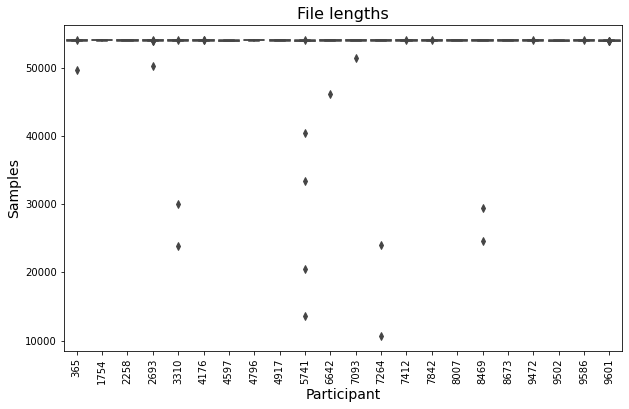

In [46]:
# dataLength_overview.sum()

dataLength_long_format = dataLength_overview.melt(var_name='Participant', value_name='Samples')


plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='Samples', data=dataLength_long_format)
#
# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Samples', fontsize=14)
plt.title('File lengths', fontsize=16)

# # Rotate x-axis labels vertically
plt.xticks(rotation=90)

plt.show()

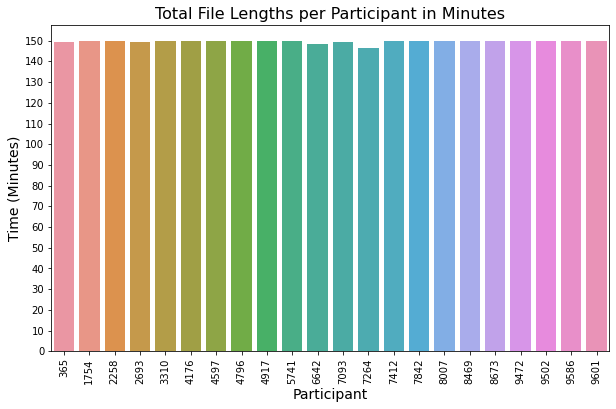

In [47]:

# Assuming dataLength_overview is your original DataFrame
fullData = dataLength_overview.sum()

# Convert the Series directly to a DataFrame
fullData_df = pd.DataFrame(fullData).reset_index()
fullData_df.columns = ['Participant', 'Samples']

# Calculate the corresponding time in minutes
fullData_df['Minutes'] = fullData_df['Samples'] / 5400  # 90 samples/sec * 60 sec/min

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for each participant showing their summed samples
sns.barplot(x='Participant', y='Minutes', data=fullData_df)

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Time (Minutes)', fontsize=14)
plt.title('Total File Lengths per Participant in Minutes', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Update y-ticks to show corresponding minutes
new_yticks = np.arange(0, fullData_df['Minutes'].max(), step=10)  # Adjust step as needed
plt.yticks(new_yticks)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'TotalFileLength_parts_min_calc1.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()


In [64]:
print('start')


dataLength_step1_overview = pd.DataFrame()
fileCountOverview = pd.DataFrame(columns=['Participant', 'Session', 'FileCount'])

# Prepare to track missing files
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])

# Loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# Overall counter for files
overall_file_counts = {}

for indexPart, currentPart in enumerate(parts_pbar):
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1, 6))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
        
    # Loop over recording sessions
    for indexSess in session_pbar:
        # Get all eye tracking session files
        fileNames = [f for f in os.listdir(data_savepath_processed_gazes) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]

        # Track missing files
        if len(fileNames) < 3:  # Adjust this threshold as needed
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)

        # If files exist, process them
        if len(fileNames) > 0:
            session_file_count = 0  # Count files per session
            
            # Files progress bar
            file_pbar = tqdm(
                iterable=fileNames,
                total=len(fileNames),
                desc="📂 ET files____________",
                dynamic_ncols=True,
                bar_format=B_FORMAT,
            )

            for file_index, file in enumerate(file_pbar):
                print('process file ', file)

                # Read in data
                data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))

                # Length (number of rows) of the data
                row_count = len(data)

                # Assuming the duration per sample; adjust if your sample duration differs
                sample_duration = data['timeStampDataPointStart_converted'].iloc[-1]/60
                session_file_count += 1
                
                uncleanDataCount = (data['cleanData'] == 0).sum()

                uncleanDataPer = uncleanDataCount/len(data)
                
                
                # Append the information to the overview DataFrame
                dataLength_step1_overview = dataLength_step1_overview.append({
                    'Participant': currentPart,
                    'Session': indexSess,
                    'ET': file_index,
                    'DataLength': row_count,
                    'SampleDuration': sample_duration,
                    'UncleanDataCount' : uncleanDataCount,
                    'uncleanDataPerc' : uncleanDataPer
                }, ignore_index=True)

            # Count the number of files processed for this participant and session
            fileCountOverview = fileCountOverview.append({
                'Participant': currentPart,
                'Session': indexSess,
                'FileCount': session_file_count
            }, ignore_index=True)
            
            # Keep a running total of files processed for each participant
            if currentPart in overall_file_counts:
                overall_file_counts[currentPart] += session_file_count
            else:
                overall_file_counts[currentPart] = session_file_count

# Optional: Convert overall file counts into a DataFrame for easier analysis
overall_file_count_df = pd.DataFrame(overall_file_counts.items(), columns=['Participant', 'TotalFileCount'])



start


📄 0 of 22 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 365


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_1_ET_1_data_processed_gazes.csv
process file  365_Session_1_ET_2_data_processed_gazes.csv
process file  365_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_2_ET_1_data_processed_gazes.csv
process file  365_Session_2_ET_2_data_processed_gazes.csv
process file  365_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_3_ET_1_data_processed_gazes.csv
process file  365_Session_3_ET_2_data_processed_gazes.csv
process file  365_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_4_ET_1_data_processed_gazes.csv
process file  365_Session_4_ET_2_data_processed_gazes.csv
process file  365_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_5_ET_1_data_processed_gazes.csv
process file  365_Session_5_ET_2_data_processed_gazes.csv
process file  365_Session_5_ET_3_data_processed_gazes.csv
Participant 1 - participant ID 1754


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_1_ET_1_data_processed_gazes.csv
process file  1754_Session_1_ET_2_data_processed_gazes.csv
process file  1754_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_2_ET_1_data_processed_gazes.csv
process file  1754_Session_2_ET_2_data_processed_gazes.csv
process file  1754_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_3_ET_1_data_processed_gazes.csv
process file  1754_Session_3_ET_2_data_processed_gazes.csv
process file  1754_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_4_ET_1_data_processed_gazes.csv
process file  1754_Session_4_ET_2_data_processed_gazes.csv
process file  1754_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_5_ET_1_data_processed_gazes.csv
process file  1754_Session_5_ET_2_data_processed_gazes.csv
process file  1754_Session_5_ET_3_data_processed_gazes.csv
Participant 2 - participant ID 2258


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_1_ET_1_data_processed_gazes.csv
process file  2258_Session_1_ET_2_data_processed_gazes.csv
process file  2258_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_2_ET_1_data_processed_gazes.csv
process file  2258_Session_2_ET_2_data_processed_gazes.csv
process file  2258_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_3_ET_1_data_processed_gazes.csv
process file  2258_Session_3_ET_2_data_processed_gazes.csv
process file  2258_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_4_ET_1_data_processed_gazes.csv
process file  2258_Session_4_ET_2_data_processed_gazes.csv
process file  2258_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_5_ET_1_data_processed_gazes.csv
process file  2258_Session_5_ET_2_data_processed_gazes.csv
process file  2258_Session_5_ET_3_data_processed_gazes.csv
Participant 3 - participant ID 2693


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_1_ET_1_data_processed_gazes.csv
process file  2693_Session_1_ET_2_data_processed_gazes.csv
process file  2693_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_2_ET_1_data_processed_gazes.csv
process file  2693_Session_2_ET_2_data_processed_gazes.csv
process file  2693_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_3_ET_1_data_processed_gazes.csv
process file  2693_Session_3_ET_2_data_processed_gazes.csv
process file  2693_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_4_ET_1_data_processed_gazes.csv
process file  2693_Session_4_ET_2_data_processed_gazes.csv
process file  2693_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_5_ET_1_data_processed_gazes.csv
process file  2693_Session_5_ET_2_data_processed_gazes.csv
process file  2693_Session_5_ET_3_data_processed_gazes.csv
Participant 4 - participant ID 3310


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_1_ET_1_data_processed_gazes.csv
process file  3310_Session_1_ET_2_data_processed_gazes.csv
process file  3310_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_2_ET_1_data_processed_gazes.csv
process file  3310_Session_2_ET_2_data_processed_gazes.csv
process file  3310_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_3_ET_1_data_processed_gazes.csv
process file  3310_Session_3_ET_2_data_processed_gazes.csv
process file  3310_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_4_ET_1_data_processed_gazes.csv
process file  3310_Session_4_ET_2_data_processed_gazes.csv
process file  3310_Session_4_ET_3_data_processed_gazes.csv
process file  3310_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_5_ET_1_data_processed_gazes.csv
process file  3310_Session_5_ET_2_data_processed_gazes.csv
process file  3310_Session_5_ET_3_data_processed_gazes.csv
Participant 5 - participant ID 4176


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_1_ET_1_data_processed_gazes.csv
process file  4176_Session_1_ET_2_data_processed_gazes.csv
process file  4176_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_2_ET_1_data_processed_gazes.csv
process file  4176_Session_2_ET_2_data_processed_gazes.csv
process file  4176_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_3_ET_1_data_processed_gazes.csv
process file  4176_Session_3_ET_2_data_processed_gazes.csv
process file  4176_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_4_ET_1_data_processed_gazes.csv
process file  4176_Session_4_ET_2_data_processed_gazes.csv
process file  4176_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_5_ET_1_data_processed_gazes.csv
process file  4176_Session_5_ET_2_data_processed_gazes.csv
process file  4176_Session_5_ET_3_data_processed_gazes.csv
Participant 6 - participant ID 4597


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_1_ET_1_data_processed_gazes.csv
process file  4597_Session_1_ET_2_data_processed_gazes.csv
process file  4597_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_2_ET_1_data_processed_gazes.csv
process file  4597_Session_2_ET_2_data_processed_gazes.csv
process file  4597_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_3_ET_1_data_processed_gazes.csv
process file  4597_Session_3_ET_2_data_processed_gazes.csv
process file  4597_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_4_ET_1_data_processed_gazes.csv
process file  4597_Session_4_ET_2_data_processed_gazes.csv
process file  4597_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_5_ET_1_data_processed_gazes.csv
process file  4597_Session_5_ET_2_data_processed_gazes.csv
process file  4597_Session_5_ET_3_data_processed_gazes.csv
Participant 7 - participant ID 4796


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_1_ET_1_data_processed_gazes.csv
process file  4796_Session_1_ET_2_data_processed_gazes.csv
process file  4796_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_2_ET_1_data_processed_gazes.csv
process file  4796_Session_2_ET_2_data_processed_gazes.csv
process file  4796_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_3_ET_1_data_processed_gazes.csv
process file  4796_Session_3_ET_2_data_processed_gazes.csv
process file  4796_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_4_ET_1_data_processed_gazes.csv
process file  4796_Session_4_ET_2_data_processed_gazes.csv
process file  4796_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_5_ET_1_data_processed_gazes.csv
process file  4796_Session_5_ET_2_data_processed_gazes.csv
process file  4796_Session_5_ET_3_data_processed_gazes.csv
Participant 8 - participant ID 4917


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_1_ET_1_data_processed_gazes.csv
process file  4917_Session_1_ET_2_data_processed_gazes.csv
process file  4917_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_2_ET_1_data_processed_gazes.csv
process file  4917_Session_2_ET_2_data_processed_gazes.csv
process file  4917_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_3_ET_1_data_processed_gazes.csv
process file  4917_Session_3_ET_2_data_processed_gazes.csv
process file  4917_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_4_ET_1_data_processed_gazes.csv
process file  4917_Session_4_ET_2_data_processed_gazes.csv
process file  4917_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_5_ET_1_data_processed_gazes.csv
process file  4917_Session_5_ET_2_data_processed_gazes.csv
process file  4917_Session_5_ET_3_data_processed_gazes.csv
Participant 9 - participant ID 5741


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_1_ET_1_data_processed_gazes.csv
process file  5741_Session_1_ET_2_data_processed_gazes.csv
process file  5741_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_2_ET_1_data_processed_gazes.csv
process file  5741_Session_2_ET_2_data_processed_gazes.csv
process file  5741_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_3_ET_1_data_processed_gazes.csv
process file  5741_Session_3_ET_2_data_processed_gazes.csv
process file  5741_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_4_ET_1_data_processed_gazes.csv
process file  5741_Session_4_ET_2_data_processed_gazes.csv
process file  5741_Session_4_ET_3_data_processed_gazes.csv
process file  5741_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_5_ET_1_data_processed_gazes.csv
process file  5741_Session_5_ET_2_data_processed_gazes.csv
process file  5741_Session_5_ET_3_data_processed_gazes.csv
process file  5741_Session_5_ET_4_data_processed_gazes.csv
Participant 10 - participant ID 6642


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_1_ET_1_data_processed_gazes.csv
process file  6642_Session_1_ET_2_data_processed_gazes.csv
process file  6642_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_2_ET_1_data_processed_gazes.csv
process file  6642_Session_2_ET_2_data_processed_gazes.csv
process file  6642_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_3_ET_1_data_processed_gazes.csv
process file  6642_Session_3_ET_2_data_processed_gazes.csv
process file  6642_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_4_ET_1_data_processed_gazes.csv
process file  6642_Session_4_ET_2_data_processed_gazes.csv
process file  6642_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_5_ET_1_data_processed_gazes.csv
process file  6642_Session_5_ET_2_data_processed_gazes.csv
process file  6642_Session_5_ET_3_data_processed_gazes.csv
Participant 11 - participant ID 7093


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_1_ET_1_data_processed_gazes.csv
process file  7093_Session_1_ET_2_data_processed_gazes.csv
process file  7093_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_2_ET_1_data_processed_gazes.csv
process file  7093_Session_2_ET_2_data_processed_gazes.csv
process file  7093_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_3_ET_1_data_processed_gazes.csv
process file  7093_Session_3_ET_2_data_processed_gazes.csv
process file  7093_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_4_ET_1_data_processed_gazes.csv
process file  7093_Session_4_ET_2_data_processed_gazes.csv
process file  7093_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_5_ET_1_data_processed_gazes.csv
process file  7093_Session_5_ET_2_data_processed_gazes.csv
process file  7093_Session_5_ET_3_data_processed_gazes.csv
Participant 12 - participant ID 7264


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_1_ET_1_data_processed_gazes.csv
process file  7264_Session_1_ET_2_data_processed_gazes.csv
process file  7264_Session_1_ET_3_data_processed_gazes.csv
process file  7264_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_2_ET_1_data_processed_gazes.csv
process file  7264_Session_2_ET_2_data_processed_gazes.csv
process file  7264_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_3_ET_1_data_processed_gazes.csv
process file  7264_Session_3_ET_2_data_processed_gazes.csv
process file  7264_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_4_ET_1_data_processed_gazes.csv
process file  7264_Session_4_ET_2_data_processed_gazes.csv
process file  7264_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_5_ET_1_data_processed_gazes.csv
process file  7264_Session_5_ET_2_data_processed_gazes.csv
process file  7264_Session_5_ET_3_data_processed_gazes.csv
Participant 13 - participant ID 7412


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_1_ET_1_data_processed_gazes.csv
process file  7412_Session_1_ET_2_data_processed_gazes.csv
process file  7412_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_2_ET_1_data_processed_gazes.csv
process file  7412_Session_2_ET_2_data_processed_gazes.csv
process file  7412_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_3_ET_1_data_processed_gazes.csv
process file  7412_Session_3_ET_2_data_processed_gazes.csv
process file  7412_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_4_ET_1_data_processed_gazes.csv
process file  7412_Session_4_ET_2_data_processed_gazes.csv
process file  7412_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_5_ET_1_data_processed_gazes.csv
process file  7412_Session_5_ET_2_data_processed_gazes.csv
process file  7412_Session_5_ET_3_data_processed_gazes.csv
Participant 14 - participant ID 7842


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_1_ET_1_data_processed_gazes.csv
process file  7842_Session_1_ET_2_data_processed_gazes.csv
process file  7842_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_2_ET_1_data_processed_gazes.csv
process file  7842_Session_2_ET_2_data_processed_gazes.csv
process file  7842_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_3_ET_1_data_processed_gazes.csv
process file  7842_Session_3_ET_2_data_processed_gazes.csv
process file  7842_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_4_ET_1_data_processed_gazes.csv
process file  7842_Session_4_ET_2_data_processed_gazes.csv
process file  7842_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_5_ET_1_data_processed_gazes.csv
process file  7842_Session_5_ET_2_data_processed_gazes.csv
process file  7842_Session_5_ET_3_data_processed_gazes.csv
Participant 15 - participant ID 8007


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_1_ET_1_data_processed_gazes.csv
process file  8007_Session_1_ET_2_data_processed_gazes.csv
process file  8007_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_2_ET_1_data_processed_gazes.csv
process file  8007_Session_2_ET_2_data_processed_gazes.csv
process file  8007_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_3_ET_1_data_processed_gazes.csv
process file  8007_Session_3_ET_2_data_processed_gazes.csv
process file  8007_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_4_ET_1_data_processed_gazes.csv
process file  8007_Session_4_ET_2_data_processed_gazes.csv
process file  8007_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_5_ET_1_data_processed_gazes.csv
process file  8007_Session_5_ET_2_data_processed_gazes.csv
process file  8007_Session_5_ET_3_data_processed_gazes.csv
Participant 16 - participant ID 8469


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_1_ET_1_data_processed_gazes.csv
process file  8469_Session_1_ET_2_data_processed_gazes.csv
process file  8469_Session_1_ET_3_data_processed_gazes.csv
process file  8469_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_2_ET_1_data_processed_gazes.csv
process file  8469_Session_2_ET_2_data_processed_gazes.csv
process file  8469_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_3_ET_1_data_processed_gazes.csv
process file  8469_Session_3_ET_2_data_processed_gazes.csv
process file  8469_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_4_ET_1_data_processed_gazes.csv
process file  8469_Session_4_ET_2_data_processed_gazes.csv
process file  8469_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_5_ET_1_data_processed_gazes.csv
process file  8469_Session_5_ET_2_data_processed_gazes.csv
process file  8469_Session_5_ET_3_data_processed_gazes.csv
Participant 17 - participant ID 8673


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_1_ET_1_data_processed_gazes.csv
process file  8673_Session_1_ET_2_data_processed_gazes.csv
process file  8673_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_2_ET_1_data_processed_gazes.csv
process file  8673_Session_2_ET_2_data_processed_gazes.csv
process file  8673_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_3_ET_1_data_processed_gazes.csv
process file  8673_Session_3_ET_2_data_processed_gazes.csv
process file  8673_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_4_ET_1_data_processed_gazes.csv
process file  8673_Session_4_ET_2_data_processed_gazes.csv
process file  8673_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_5_ET_1_data_processed_gazes.csv
process file  8673_Session_5_ET_2_data_processed_gazes.csv
process file  8673_Session_5_ET_3_data_processed_gazes.csv
Participant 18 - participant ID 9472


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_1_ET_1_data_processed_gazes.csv
process file  9472_Session_1_ET_2_data_processed_gazes.csv
process file  9472_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_2_ET_1_data_processed_gazes.csv
process file  9472_Session_2_ET_2_data_processed_gazes.csv
process file  9472_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_3_ET_1_data_processed_gazes.csv
process file  9472_Session_3_ET_2_data_processed_gazes.csv
process file  9472_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_4_ET_1_data_processed_gazes.csv
process file  9472_Session_4_ET_2_data_processed_gazes.csv
process file  9472_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_5_ET_1_data_processed_gazes.csv
process file  9472_Session_5_ET_2_data_processed_gazes.csv
process file  9472_Session_5_ET_3_data_processed_gazes.csv
Participant 19 - participant ID 9502


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_1_ET_1_data_processed_gazes.csv
process file  9502_Session_1_ET_2_data_processed_gazes.csv
process file  9502_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_2_ET_1_data_processed_gazes.csv
process file  9502_Session_2_ET_2_data_processed_gazes.csv
process file  9502_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_3_ET_1_data_processed_gazes.csv
process file  9502_Session_3_ET_2_data_processed_gazes.csv
process file  9502_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_4_ET_1_data_processed_gazes.csv
process file  9502_Session_4_ET_2_data_processed_gazes.csv
process file  9502_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_5_ET_1_data_processed_gazes.csv
process file  9502_Session_5_ET_2_data_processed_gazes.csv
process file  9502_Session_5_ET_3_data_processed_gazes.csv
Participant 20 - participant ID 9586


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_1_ET_1_data_processed_gazes.csv
process file  9586_Session_1_ET_2_data_processed_gazes.csv
process file  9586_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_2_ET_1_data_processed_gazes.csv
process file  9586_Session_2_ET_2_data_processed_gazes.csv
process file  9586_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_3_ET_1_data_processed_gazes.csv
process file  9586_Session_3_ET_2_data_processed_gazes.csv
process file  9586_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_4_ET_1_data_processed_gazes.csv
process file  9586_Session_4_ET_2_data_processed_gazes.csv
process file  9586_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_5_ET_1_data_processed_gazes.csv
process file  9586_Session_5_ET_2_data_processed_gazes.csv
process file  9586_Session_5_ET_3_data_processed_gazes.csv
Participant 21 - participant ID 9601


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_1_ET_1_data_processed_gazes.csv
process file  9601_Session_1_ET_2_data_processed_gazes.csv
process file  9601_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_2_ET_1_data_processed_gazes.csv
process file  9601_Session_2_ET_2_data_processed_gazes.csv
process file  9601_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_3_ET_1_data_processed_gazes.csv
process file  9601_Session_3_ET_2_data_processed_gazes.csv
process file  9601_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_4_ET_1_data_processed_gazes.csv
process file  9601_Session_4_ET_2_data_processed_gazes.csv
process file  9601_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_5_ET_1_data_processed_gazes.csv
process file  9601_Session_5_ET_2_data_processed_gazes.csv
process file  9601_Session_5_ET_3_data_processed_gazes.csv


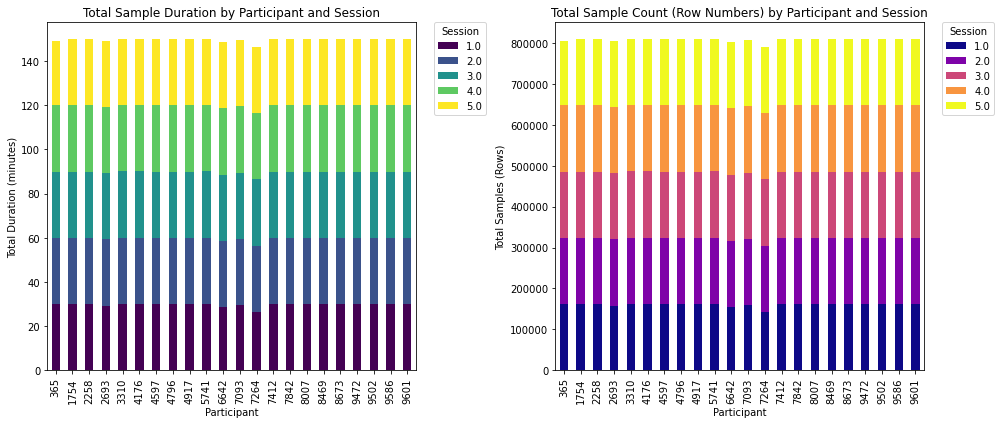

In [66]:
# Total Duration by Participant and Session
duration_summary = dataLength_step1_overview.groupby(['Participant', 'Session'])['SampleDuration'].sum().unstack(fill_value=0)
duration_summary = duration_summary.fillna(0)  # Make sure there are no NaN values

# Total Sample Count (DataLength) by Participant and Session
sample_summary = dataLength_step1_overview.groupby(['Participant', 'Session'])['DataLength'].sum().unstack(fill_value=0)
sample_summary = sample_summary.fillna(0)  # Make sure there are no NaN values

# Plotting Stacked Bar Plots for Sample Duration
plt.figure(figsize=(14, 6))

# Stacked bar plot for Sample Duration
plt.subplot(1, 2, 1)
duration_summary.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title('Total Sample Duration by Participant and Session')
plt.xlabel('Participant')
plt.ylabel('Total Duration (minutes)')
plt.legend(title='Session', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.gca().set_xticklabels(duration_summary.index.astype(int)) 

# Stacked bar plot for Sample Count
plt.subplot(1, 2, 2)
sample_summary.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='plasma')
plt.title('Total Sample Count (Row Numbers) by Participant and Session')
plt.xlabel('Participant')
plt.ylabel('Total Samples (Rows)')
plt.legend(title='Session', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.gca().set_xticklabels(duration_summary.index.astype(int)) 

plt.tight_layout()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'total_data_length_sessions.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()


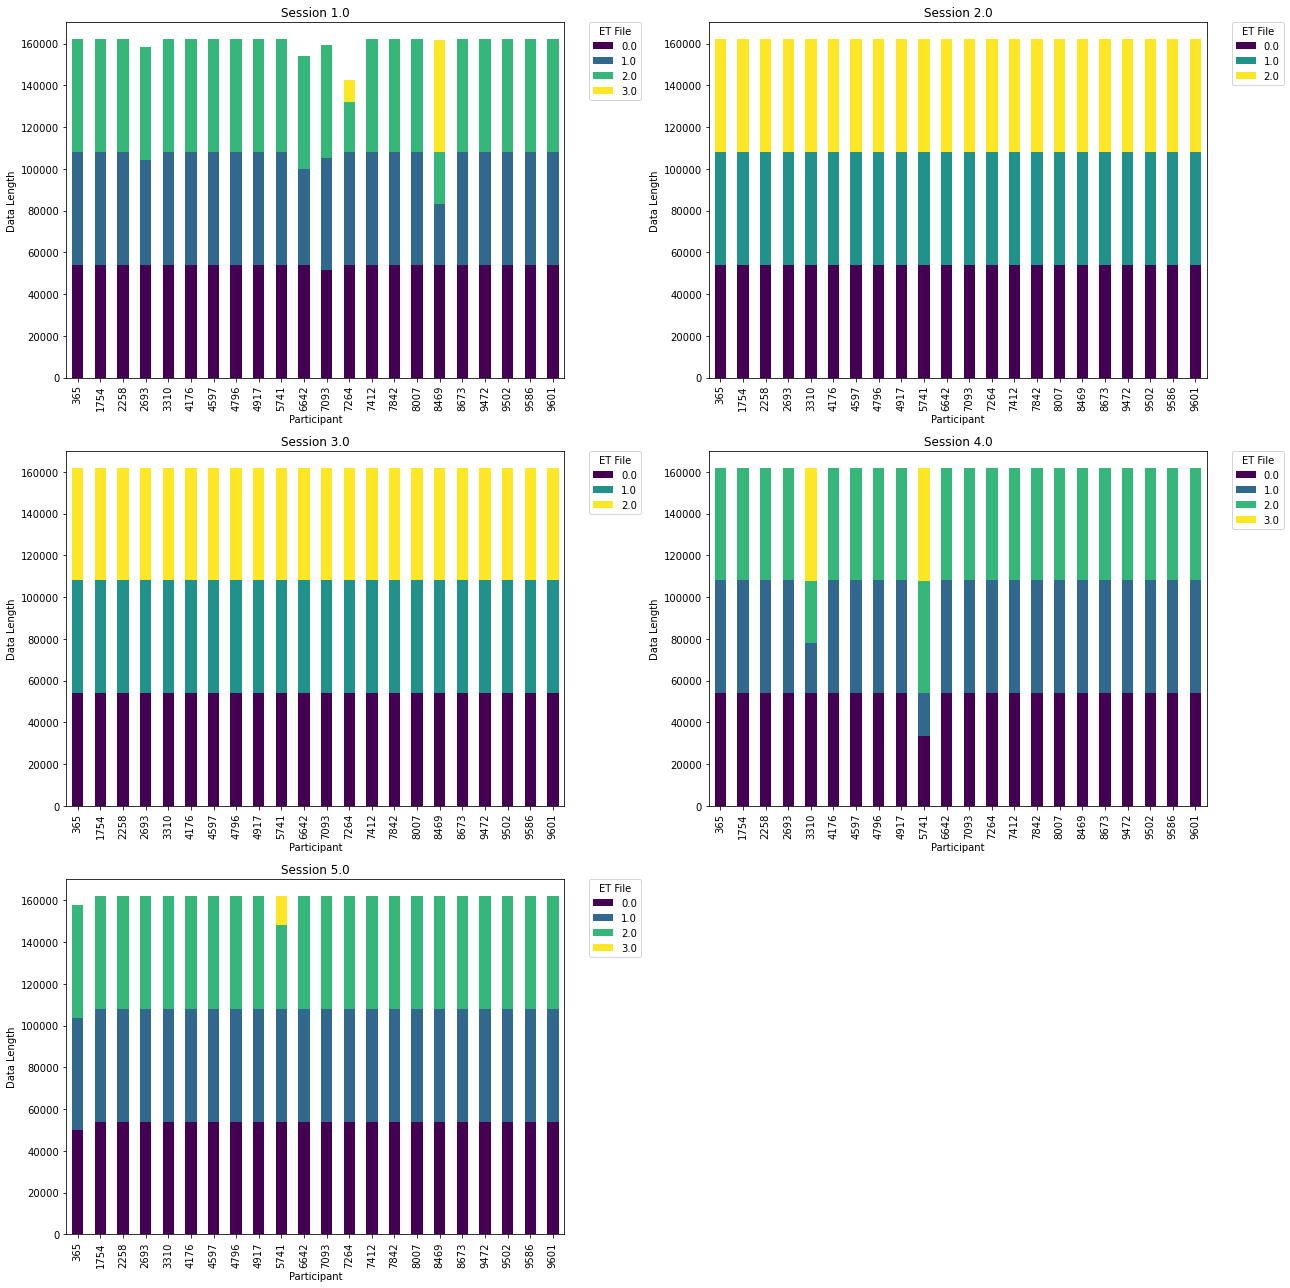

In [67]:
# Assuming you already have the data in your 'dataLength_step1_overview' DataFrame
data = dataLength_step1_overview

# List all unique sessions
unique_sessions = data['Session'].unique()

# Create a 3x2 grid for the plots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each session on the grid
plot_counter = 0
for session in unique_sessions:
    # Filter data for the specific session
    session_data = data[data['Session'] == session]

    # Pivot the data to create a DataFrame suitable for stacked bar plotting
    pivot_df = session_data.pivot_table(
        index='Participant',
        columns='ET',
        values='DataLength',
        aggfunc='sum',
        fill_value=0
    )
    
    # Plot the stacked bar plot in the current subplot
    pivot_df.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[plot_counter])

    # Add labels and title
    axes[plot_counter].set_xlabel('Participant')
    axes[plot_counter].set_ylabel('Data Length')
    axes[plot_counter].set_title(f'Session {session}')
    axes[plot_counter].legend(title='ET File', bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

    # Set x labels to be integers without decimal
    # Set the x-tick labels using participant IDs
    axes[plot_counter].set_xticks(range(len(pivot_df.index)))
    axes[plot_counter].set_xticklabels(pivot_df.index.astype(int), rotation=90)
    
    plot_counter += 1

# Hide unused subplots (if any)
for i in range(plot_counter, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'total_data_length_5sessions_etfiles.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()


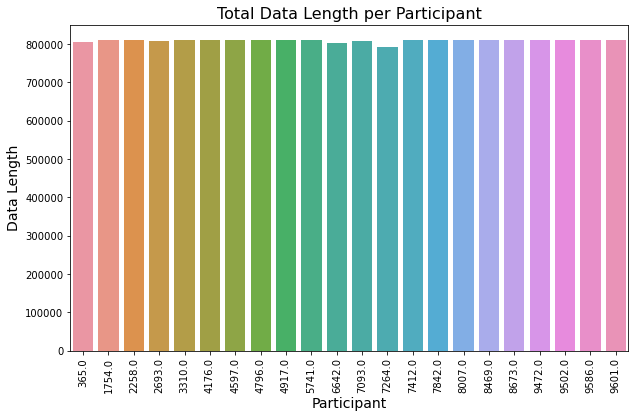

In [97]:
# Summing DataLength for each participant
summed_data = dataLength_step1_overview.groupby('Participant')['DataLength'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for each participant showing their summed samples
sns.barplot(x='Participant', y='DataLength', data=summed_data)

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Data Length', fontsize=14)
plt.title('Total Data Length per Participant', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'total_data_length_samples_calc2.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

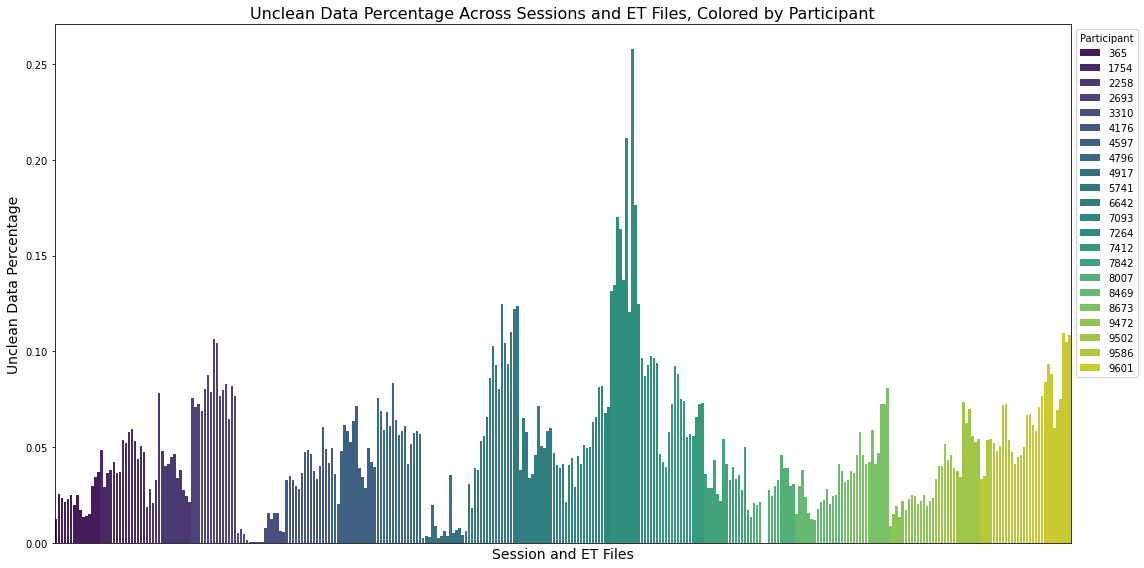

In [100]:
# Concatenate Session and ET for a unique x-axis identifier
dataLength_step1_overview['Session_ET'] = dataLength_step1_overview.apply(lambda row: f"S{row['Session']}_ET{row['ET']}", axis=1)

# Create a unique identifier for plots
dataLength_step1_overview['Session_ET_idx'] = dataLength_step1_overview.index

# Plotting
plt.figure(figsize=(16, 8))
sns.barplot(data=dataLength_step1_overview, x='Session_ET_idx', y='uncleanDataPerc', hue='Participant', dodge=False, palette='viridis')
plt.xticks([])
# Add labels and title
plt.xlabel('Session and ET Files', fontsize=14)
plt.ylabel('Unclean Data Percentage', fontsize=14)
plt.title('Unclean Data Percentage Across Sessions and ET Files, Colored by Participant', fontsize=16)


# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
# Convert labels to integers if needed
labels = [int(float(label)) for label in labels]
plt.legend(handles, labels, title='Participant',  loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'percentage_missingData_allFiles.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

In [77]:
uncleanFiles = dataLength_step1_overview[dataLength_step1_overview['uncleanDataPerc']>0.2]
uncleanFiles.head()

,DataLength,ET,Participant,SampleDuration,Session,UncleanDataCount,uncleanDataPerc,Session_ET,Session_ET_idx
188,54000.0,1.0,7264.0,9.999834,2.0,11418.0,0.211444,S2.0_ET1.0,188
190,54002.0,0.0,7264.0,10.000132,3.0,13925.0,0.257861,S3.0_ET0.0,190


# gaze and saccade stats and plots

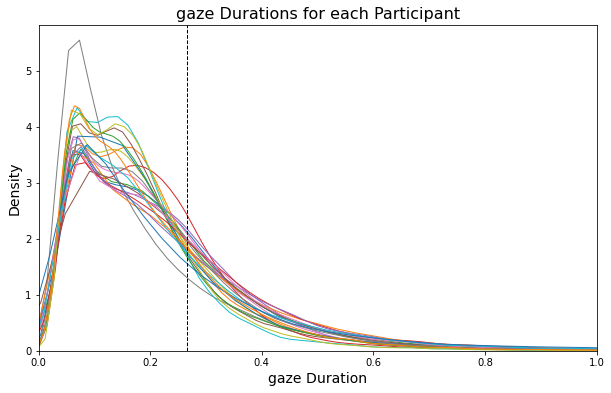

In [78]:
# Approach 1: Plot each participant's gaze durations individually with only the KDE visible
plt.figure(figsize=(10, 6))

for participant in gaze_lengths.columns:
    sns.kdeplot(gaze_lengths[participant].dropna(), label=f'Participant {participant}', linewidth=1)
    
plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('gaze Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('gaze Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'gaze_durations_participants.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

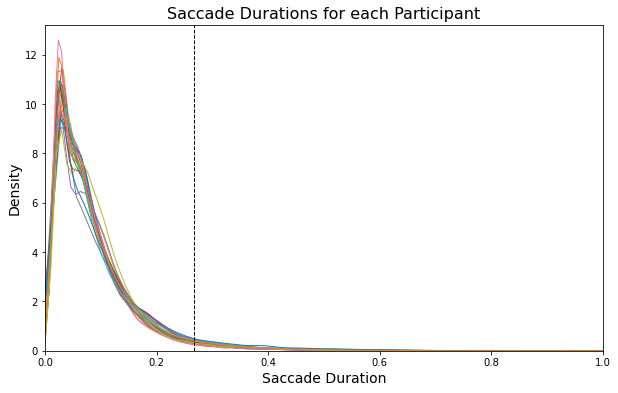

In [79]:
plt.figure(figsize=(10, 6))

for participant in saccade_lengths.columns:
    sns.kdeplot(saccade_lengths[participant].dropna(), label=f'Participant {participant}', linewidth=1)
    
plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Saccade Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Saccade Durations for each Participant', fontsize=16)

# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'saccade_durations_participants.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

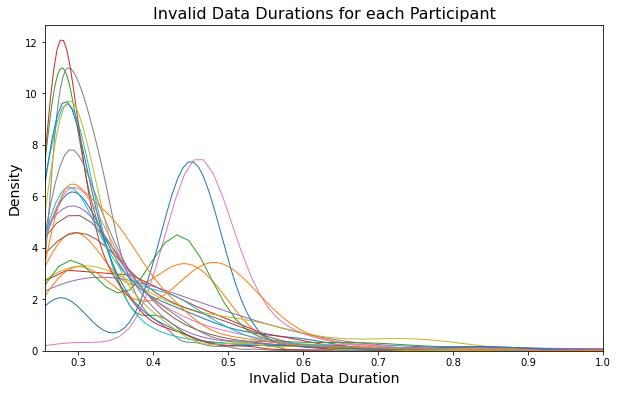

In [80]:
# Check no data distributions
plt.figure(figsize=(10, 6))

# Initialize the minimum value variable
global_min_value = float('inf')

for participant in noData_lengths.columns:
    # Drop NaN values for the participant's data
    participant_data = noData_lengths[participant].dropna()
    
    # Plot the KDE for the participant
    sns.kdeplot(participant_data, label=f'Participant {participant}', linewidth=1)
    
    # Update the global minimum value
    min_value = participant_data.min()
    if min_value < global_min_value:
        global_min_value = min_value

# Add a vertical line for the 0.25 threshold
plt.axvline(x=0.25, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis based on the minimum value and the specified range
plt.xlim(max(0.25, global_min_value), 1)

# Add labels and title
plt.xlabel('Invalid Data Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Invalid Data Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'invalidData_durations_participants.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

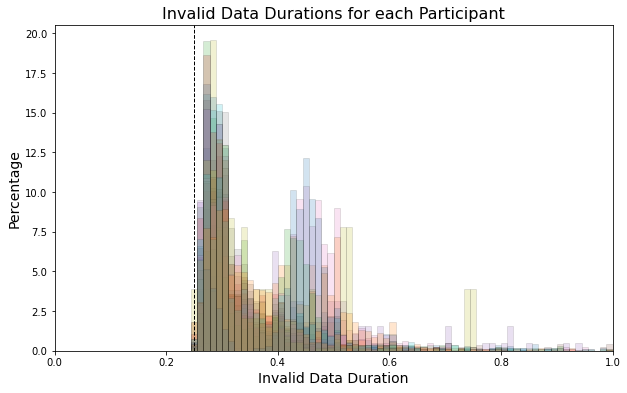

In [81]:
# Define uniform bin width based on the sampling rate of 1/90
bin_width = 1/90

# Check no data distributions
plt.figure(figsize=(10, 6))

# Plot histogram for each participant with low alpha
for participant in noData_lengths.columns:
    participant_data = noData_lengths[participant].dropna()
    plt.hist(participant_data, bins=np.arange(0, 1 + bin_width, bin_width), alpha=0.2, edgecolor='black', linewidth=0.5, density = True)

# Add a vertical line for the 0.25 threshold
plt.axvline(x=0.25, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Invalid Data Duration', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Invalid Data Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'invalidData_durations_participants_hist.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [82]:
# Combine gaze durations across all participants
combined_gaze_data = pd.concat([gaze_lengths[col].dropna() for col in gaze_lengths.columns])

# Combine saccade durations across all participants
combined_saccade_data = pd.concat([saccade_lengths[col].dropna() for col in saccade_lengths.columns])

combined_noData_data = pd.concat([noData_lengths[col].dropna() for col in noData_lengths.columns])

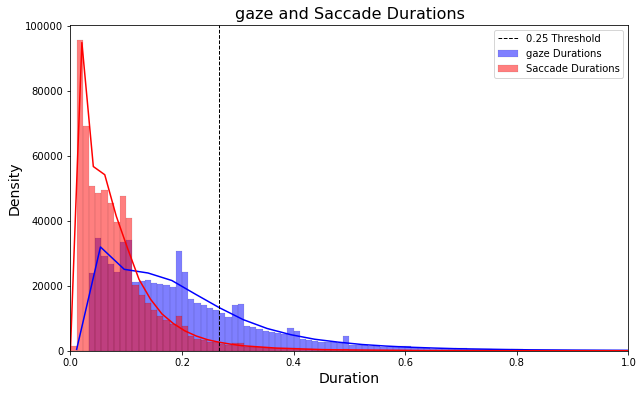

In [83]:
binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(combined_gaze_data, kde=True, color='blue', label='gaze Durations', binwidth=binwidth )

# Plot KDE for saccade durations in red
sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('gaze and Saccade Durations', fontsize=16)

plt.xlim(0, 1)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'gaze_saccade_durations_allData.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


135331.73333333185
56449.02222221831
5792.788888888913


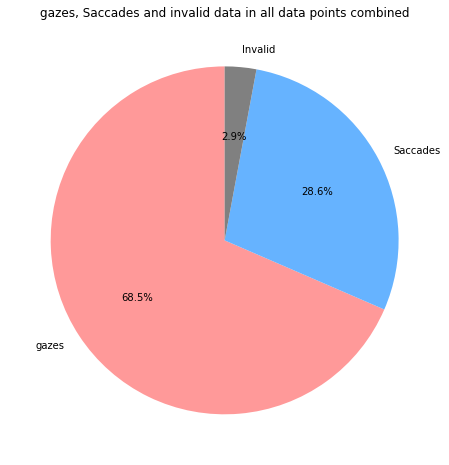

In [84]:
# Combine gaze durations across all participants
combined_gaze_data = pd.concat([gaze_lengths[col].dropna() for col in gaze_lengths.columns])

# Combine saccade durations across all participants
combined_saccade_data = pd.concat([saccade_lengths[col].dropna() for col in saccade_lengths.columns])

combined_noData_data = pd.concat([noData_lengths[col].dropna() for col in noData_lengths.columns])

# Calculate the lengths
# gaze_sum = combined_gaze_data.sum()
# saccade_sum = combined_saccade_data.sum()
# noData_sum = combined_noData_data.sum()

gaze_sum = gaze_lengths.sum().sum()
saccade_sum = saccade_lengths.sum().sum()
noData_sum = noData_lengths.sum().sum()

allD = gaze_sum + saccade_sum + noData_sum
print(gaze_sum)
print(saccade_sum)
print(noData_sum)


# Combine lengths into a list
lengths = [gaze_sum, saccade_sum, noData_sum]

# Define labels for the pie chart
labels = ['gazes', 'Saccades', 'Invalid']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','grey'])
plt.title('gazes, Saccades and invalid data in all data points combined')


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'allData_gazes_durations_invalidData_sum.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

6151.4424242423565
2565.8646464644685
263.3085858585869


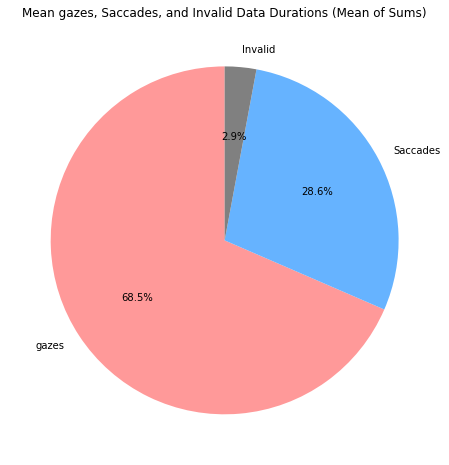

In [85]:
# Calculate the sum durations for each participant

# Calculate the means of the sums
gaze_mean_of_sums =  gaze_lengths.sum().mean()
saccade_mean_of_sums = saccade_lengths.sum().mean()
noData_mean_of_sums = noData_lengths.sum().mean()

allD = gaze_mean_of_sums + saccade_mean_of_sums + noData_mean_of_sums
print(gaze_mean_of_sums)
print(saccade_mean_of_sums)
print(noData_mean_of_sums)

# Combine mean sums into a list
mean_sums = [gaze_mean_of_sums, saccade_mean_of_sums, noData_mean_of_sums]

# Define labels for the pie chart
labels = ['gazes', 'Saccades', 'Invalid']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(mean_sums, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','grey'])
plt.title('Mean gazes, Saccades, and Invalid Data Durations (Mean of Sums)')


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'allData_gazes_durations_invalidData_mean.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


# Show the figure
plt.show()


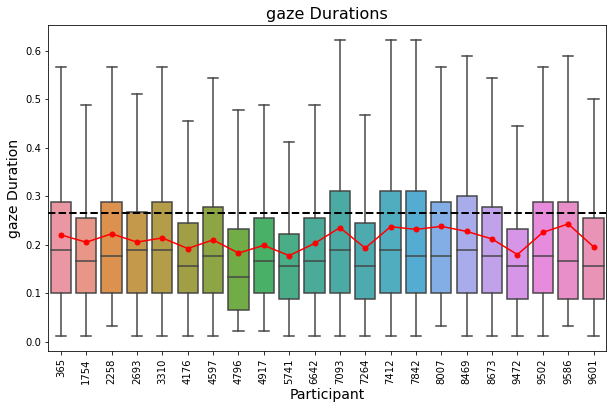

In [86]:
# Assuming you have dataframes: gaze_lengths

# Define the save path and file name separately

# Prepare data for boxplot
gaze_long_format = gaze_lengths.melt(var_name='Participant', value_name='gaze_Duration')

plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='gaze_Duration', data=gaze_long_format, showfliers=False)

# Calculate and plot means
means = gaze_lengths.mean()
ax.plot(range(len(means)), means, marker='o', markersize=5, color='red', linestyle='-', label='Mean')

# Plot the 0.25 threshold line
plt.axhline(y=0.2666, color='black', linestyle='--', linewidth=2, label='0.266.6 Threshold')

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('gaze Duration', fontsize=14)
plt.title('gaze Durations', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


filename = 'gaze_durations_boxplots.png'
full_save_path = os.path.join(data_savepath_plots, filename)

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


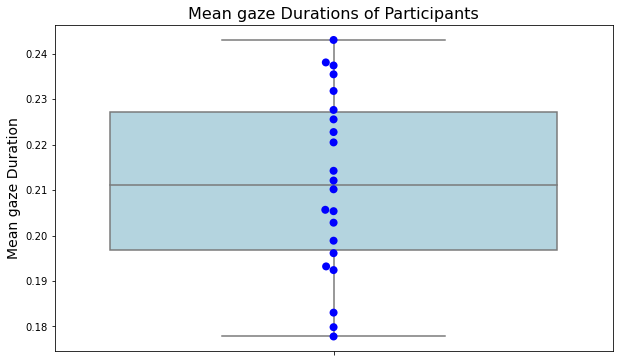

In [87]:

# Calculate the mean gaze duration for each participant
means = gaze_lengths.mean()

# Convert the means to a DataFrame for plotting
means_df = pd.DataFrame(means, columns=['Mean_gaze_Duration'])
means_df.reset_index(inplace=True)
means_df.rename(columns={'index': 'Participant'}, inplace=True)

plt.figure(figsize=(10, 6))

# Plot boxplot of the means
ax = sns.boxplot(y='Mean_gaze_Duration', data=means_df, color='lightblue', showfliers=False)
ax = sns.swarmplot(y='Mean_gaze_Duration', data=means_df, color='blue', size=8)  # Add swarm plot for better visibility of points

# Add labels and title
plt.ylabel('Mean gaze Duration', fontsize=14)
plt.title('Mean gaze Durations of Participants', fontsize=16)

# Save the figure
filename = 'mean_gaze_durations_boxplot.png'
full_save_path = os.path.join(data_savepath_plots, filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


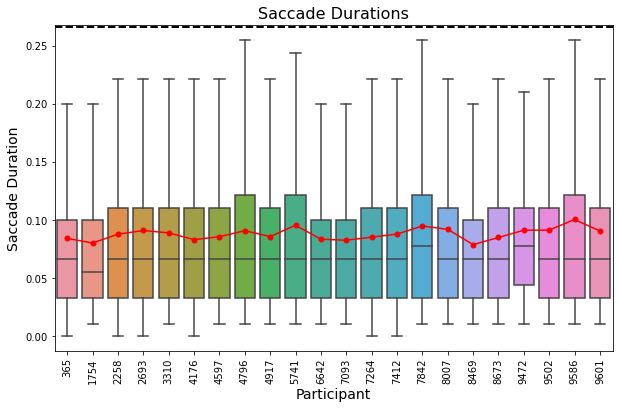

In [88]:
# Assuming you have dataframes: gaze_lengths

# Define the save path and file name separately

# Prepare data for boxplot
saccade_long_format = saccade_lengths.melt(var_name='Participant', value_name='Saccade_Duration')

plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='Saccade_Duration', data=saccade_long_format, showfliers=False)

# Calculate and plot means
means = saccade_lengths.mean()
ax.plot(range(len(means)), means, marker='o', markersize=5, color='red', linestyle='-', label='Mean')

# Plot the 0.25 threshold line
plt.axhline(y=0.2666, color='black', linestyle='--', linewidth=2, label='266.6 ms Threshold')

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Saccade Duration', fontsize=14)
plt.title('Saccade Durations', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


filename = 'saccade_durations_boxplots.png'
full_save_path = os.path.join(data_savepath_plots, filename)

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


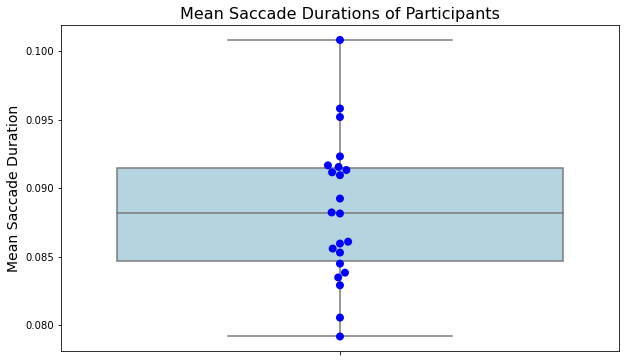

In [89]:

# Calculate the mean gaze duration for each participant
means = saccade_lengths.mean()

# Convert the means to a DataFrame for plotting
means_df = pd.DataFrame(means, columns=['Mean_Saccade_Duration'])
means_df.reset_index(inplace=True)
means_df.rename(columns={'index': 'Participant'}, inplace=True)

plt.figure(figsize=(10, 6))

# Plot boxplot of the means
ax = sns.boxplot(y='Mean_Saccade_Duration', data=means_df, color='lightblue', showfliers=False)
ax = sns.swarmplot(y='Mean_Saccade_Duration', data=means_df, color='blue', size=8)  # Add swarm plot for better visibility of points

# Add labels and title
plt.ylabel('Mean Saccade Duration', fontsize=14)
plt.title('Mean Saccade Durations of Participants', fontsize=16)

# Save the figure
filename = 'mean_saccade_durations_boxplot.png'
full_save_path = os.path.join(data_savepath_plots, filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


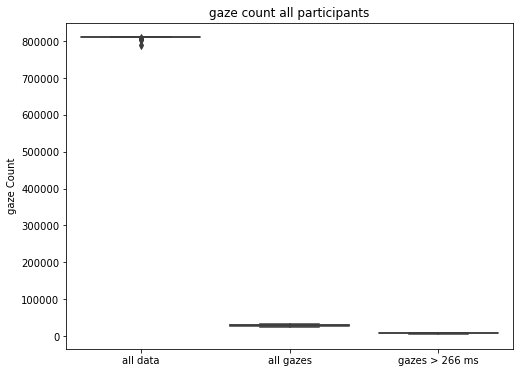

In [101]:


# Count non-NaN values in each column
non_nan_counts = gaze_lengths.notna().sum()

non_nan_dataL = dataLength_overview.notna().sum()


# Count non-NaN values greater than 250 in each column
greater_than_250_counts = gaze_lengths[gaze_lengths > 0.2666].notna().sum()

noBuilding_allFix = gaze_lengths[gaze_lengths > 0.2666].notna().sum()



# Prepare the data for boxplot
counts_df = pd.DataFrame({
    'all data': dataLength_overview.sum(),
    'all gazes': non_nan_counts,
    'gazes > 266 ms': greater_than_250_counts
})





# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=counts_df)
plt.title('gaze count all participants')
plt.ylabel('gaze Count')




# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'allData_gazes_durations_invalidData_sum.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')



plt.show()

# intervals

In [91]:
intervals = pd.DataFrame()




# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    gaze_durations = []
    saccade_durations = []
    noD_durations = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intervals) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_interval_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for fileIndex, file in enumerate(file_pbar):

            print('process file ', file)

            # read in data
            int_data = pd.read_csv(os.path.join(data_savepath_intervals, file))
            
            
              # Add participant index, session index, and file index to the data
            int_data['Participant'] = currentPart
            int_data['Session'] = indexSess
            int_data['FileIndex'] = fileIndex

            # Append the interval data to the long-form DataFrame
            intervals = pd.concat([intervals, int_data], ignore_index=True)

# Save the final intervals DataFrame
intervals.to_csv(os.path.join(data_savepath_intervals, 'aggregated_intervals.csv'), index=False)
            




            # file = "1004_Session_1_ET_1_data_processed_gazes.csv"
            # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


#             # Variables to store start times
#             gaze_start_time = None
#             saccade_start_time = None

#             # Iterate through the DataFrame to find start and end times
#             for index, row in data.iterrows():
#                 if row['events'] == 2.0:
#                     gaze_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -2.0 and gaze_start_time is not None:
#                     gaze_durations.append((row['timeStampDataPointStart_converted'] - gaze_start_time))
#                     gaze_start_time = None
#                 elif row['events'] == 1.0:
#                     saccade_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -1.0 and saccade_start_time is not None:
#                     saccade_durations.append((row['timeStampDataPointStart_converted'] - saccade_start_time))
#                     saccade_start_time = None

📄 0 of 22 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 365


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_1_ET_1_interval_mad_wobig.csv
process file  365_Session_1_ET_2_interval_mad_wobig.csv
process file  365_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_2_ET_1_interval_mad_wobig.csv
process file  365_Session_2_ET_2_interval_mad_wobig.csv
process file  365_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_3_ET_1_interval_mad_wobig.csv
process file  365_Session_3_ET_2_interval_mad_wobig.csv
process file  365_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_4_ET_1_interval_mad_wobig.csv
process file  365_Session_4_ET_2_interval_mad_wobig.csv
process file  365_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_5_ET_1_interval_mad_wobig.csv
process file  365_Session_5_ET_2_interval_mad_wobig.csv
process file  365_Session_5_ET_3_interval_mad_wobig.csv
Participant 1 - participant ID 1754


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_1_ET_1_interval_mad_wobig.csv
process file  1754_Session_1_ET_2_interval_mad_wobig.csv
process file  1754_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_2_ET_1_interval_mad_wobig.csv
process file  1754_Session_2_ET_2_interval_mad_wobig.csv
process file  1754_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_3_ET_1_interval_mad_wobig.csv
process file  1754_Session_3_ET_2_interval_mad_wobig.csv
process file  1754_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_4_ET_1_interval_mad_wobig.csv
process file  1754_Session_4_ET_2_interval_mad_wobig.csv
process file  1754_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_5_ET_1_interval_mad_wobig.csv
process file  1754_Session_5_ET_2_interval_mad_wobig.csv
process file  1754_Session_5_ET_3_interval_mad_wobig.csv
Participant 2 - participant ID 2258


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_1_ET_1_interval_mad_wobig.csv
process file  2258_Session_1_ET_2_interval_mad_wobig.csv
process file  2258_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_2_ET_1_interval_mad_wobig.csv
process file  2258_Session_2_ET_2_interval_mad_wobig.csv
process file  2258_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_3_ET_1_interval_mad_wobig.csv
process file  2258_Session_3_ET_2_interval_mad_wobig.csv
process file  2258_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_4_ET_1_interval_mad_wobig.csv
process file  2258_Session_4_ET_2_interval_mad_wobig.csv
process file  2258_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_5_ET_1_interval_mad_wobig.csv
process file  2258_Session_5_ET_2_interval_mad_wobig.csv
process file  2258_Session_5_ET_3_interval_mad_wobig.csv
Participant 3 - participant ID 2693


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_1_ET_1_interval_mad_wobig.csv
process file  2693_Session_1_ET_2_interval_mad_wobig.csv
process file  2693_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_2_ET_1_interval_mad_wobig.csv
process file  2693_Session_2_ET_2_interval_mad_wobig.csv
process file  2693_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_3_ET_1_interval_mad_wobig.csv
process file  2693_Session_3_ET_2_interval_mad_wobig.csv
process file  2693_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_4_ET_1_interval_mad_wobig.csv
process file  2693_Session_4_ET_2_interval_mad_wobig.csv
process file  2693_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_5_ET_1_interval_mad_wobig.csv
process file  2693_Session_5_ET_2_interval_mad_wobig.csv
process file  2693_Session_5_ET_3_interval_mad_wobig.csv
Participant 4 - participant ID 3310


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_1_ET_1_interval_mad_wobig.csv
process file  3310_Session_1_ET_2_interval_mad_wobig.csv
process file  3310_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_2_ET_1_interval_mad_wobig.csv
process file  3310_Session_2_ET_2_interval_mad_wobig.csv
process file  3310_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_3_ET_1_interval_mad_wobig.csv
process file  3310_Session_3_ET_2_interval_mad_wobig.csv
process file  3310_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_4_ET_1_interval_mad_wobig.csv
process file  3310_Session_4_ET_2_interval_mad_wobig.csv
process file  3310_Session_4_ET_3_interval_mad_wobig.csv
process file  3310_Session_4_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_5_ET_1_interval_mad_wobig.csv
process file  3310_Session_5_ET_2_interval_mad_wobig.csv
process file  3310_Session_5_ET_3_interval_mad_wobig.csv
Participant 5 - participant ID 4176


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_1_ET_1_interval_mad_wobig.csv
process file  4176_Session_1_ET_2_interval_mad_wobig.csv
process file  4176_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_2_ET_1_interval_mad_wobig.csv
process file  4176_Session_2_ET_2_interval_mad_wobig.csv
process file  4176_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_3_ET_1_interval_mad_wobig.csv
process file  4176_Session_3_ET_2_interval_mad_wobig.csv
process file  4176_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_4_ET_1_interval_mad_wobig.csv
process file  4176_Session_4_ET_2_interval_mad_wobig.csv
process file  4176_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_5_ET_1_interval_mad_wobig.csv
process file  4176_Session_5_ET_2_interval_mad_wobig.csv
process file  4176_Session_5_ET_3_interval_mad_wobig.csv
Participant 6 - participant ID 4597


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_1_ET_1_interval_mad_wobig.csv
process file  4597_Session_1_ET_2_interval_mad_wobig.csv
process file  4597_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_2_ET_1_interval_mad_wobig.csv
process file  4597_Session_2_ET_2_interval_mad_wobig.csv
process file  4597_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_3_ET_1_interval_mad_wobig.csv
process file  4597_Session_3_ET_2_interval_mad_wobig.csv
process file  4597_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_4_ET_1_interval_mad_wobig.csv
process file  4597_Session_4_ET_2_interval_mad_wobig.csv
process file  4597_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_5_ET_1_interval_mad_wobig.csv
process file  4597_Session_5_ET_2_interval_mad_wobig.csv
process file  4597_Session_5_ET_3_interval_mad_wobig.csv
Participant 7 - participant ID 4796


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_1_ET_1_interval_mad_wobig.csv
process file  4796_Session_1_ET_2_interval_mad_wobig.csv
process file  4796_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_2_ET_1_interval_mad_wobig.csv
process file  4796_Session_2_ET_2_interval_mad_wobig.csv
process file  4796_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_3_ET_1_interval_mad_wobig.csv
process file  4796_Session_3_ET_2_interval_mad_wobig.csv
process file  4796_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_4_ET_1_interval_mad_wobig.csv
process file  4796_Session_4_ET_2_interval_mad_wobig.csv
process file  4796_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_5_ET_1_interval_mad_wobig.csv
process file  4796_Session_5_ET_2_interval_mad_wobig.csv
process file  4796_Session_5_ET_3_interval_mad_wobig.csv
Participant 8 - participant ID 4917


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_1_ET_1_interval_mad_wobig.csv
process file  4917_Session_1_ET_2_interval_mad_wobig.csv
process file  4917_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_2_ET_1_interval_mad_wobig.csv
process file  4917_Session_2_ET_2_interval_mad_wobig.csv
process file  4917_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_3_ET_1_interval_mad_wobig.csv
process file  4917_Session_3_ET_2_interval_mad_wobig.csv
process file  4917_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_4_ET_1_interval_mad_wobig.csv
process file  4917_Session_4_ET_2_interval_mad_wobig.csv
process file  4917_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_5_ET_1_interval_mad_wobig.csv
process file  4917_Session_5_ET_2_interval_mad_wobig.csv
process file  4917_Session_5_ET_3_interval_mad_wobig.csv
Participant 9 - participant ID 5741


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_1_ET_1_interval_mad_wobig.csv
process file  5741_Session_1_ET_2_interval_mad_wobig.csv
process file  5741_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_2_ET_1_interval_mad_wobig.csv
process file  5741_Session_2_ET_2_interval_mad_wobig.csv
process file  5741_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_3_ET_1_interval_mad_wobig.csv
process file  5741_Session_3_ET_2_interval_mad_wobig.csv
process file  5741_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_4_ET_1_interval_mad_wobig.csv
process file  5741_Session_4_ET_2_interval_mad_wobig.csv
process file  5741_Session_4_ET_3_interval_mad_wobig.csv
process file  5741_Session_4_ET_4_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_5_ET_1_interval_mad_wobig.csv
process file  5741_Session_5_ET_2_interval_mad_wobig.csv
process file  5741_Session_5_ET_3_interval_mad_wobig.csv
process file  5741_Session_5_ET_4_interval_mad_wobig.csv
Participant 10 - participant ID 6642


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_1_ET_1_interval_mad_wobig.csv
process file  6642_Session_1_ET_2_interval_mad_wobig.csv
process file  6642_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_2_ET_1_interval_mad_wobig.csv
process file  6642_Session_2_ET_2_interval_mad_wobig.csv
process file  6642_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_3_ET_1_interval_mad_wobig.csv
process file  6642_Session_3_ET_2_interval_mad_wobig.csv
process file  6642_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_4_ET_1_interval_mad_wobig.csv
process file  6642_Session_4_ET_2_interval_mad_wobig.csv
process file  6642_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_5_ET_1_interval_mad_wobig.csv
process file  6642_Session_5_ET_2_interval_mad_wobig.csv
process file  6642_Session_5_ET_3_interval_mad_wobig.csv
Participant 11 - participant ID 7093


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_1_ET_1_interval_mad_wobig.csv
process file  7093_Session_1_ET_2_interval_mad_wobig.csv
process file  7093_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_2_ET_1_interval_mad_wobig.csv
process file  7093_Session_2_ET_2_interval_mad_wobig.csv
process file  7093_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_3_ET_1_interval_mad_wobig.csv
process file  7093_Session_3_ET_2_interval_mad_wobig.csv
process file  7093_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_4_ET_1_interval_mad_wobig.csv
process file  7093_Session_4_ET_2_interval_mad_wobig.csv
process file  7093_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_5_ET_1_interval_mad_wobig.csv
process file  7093_Session_5_ET_2_interval_mad_wobig.csv
process file  7093_Session_5_ET_3_interval_mad_wobig.csv
Participant 12 - participant ID 7264


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_1_ET_1_interval_mad_wobig.csv
process file  7264_Session_1_ET_2_interval_mad_wobig.csv
process file  7264_Session_1_ET_3_interval_mad_wobig.csv
process file  7264_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_2_ET_1_interval_mad_wobig.csv
process file  7264_Session_2_ET_2_interval_mad_wobig.csv
process file  7264_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_3_ET_1_interval_mad_wobig.csv
process file  7264_Session_3_ET_2_interval_mad_wobig.csv
process file  7264_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_4_ET_1_interval_mad_wobig.csv
process file  7264_Session_4_ET_2_interval_mad_wobig.csv
process file  7264_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_5_ET_1_interval_mad_wobig.csv
process file  7264_Session_5_ET_2_interval_mad_wobig.csv
process file  7264_Session_5_ET_3_interval_mad_wobig.csv
Participant 13 - participant ID 7412


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_1_ET_1_interval_mad_wobig.csv
process file  7412_Session_1_ET_2_interval_mad_wobig.csv
process file  7412_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_2_ET_1_interval_mad_wobig.csv
process file  7412_Session_2_ET_2_interval_mad_wobig.csv
process file  7412_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_3_ET_1_interval_mad_wobig.csv
process file  7412_Session_3_ET_2_interval_mad_wobig.csv
process file  7412_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_4_ET_1_interval_mad_wobig.csv
process file  7412_Session_4_ET_2_interval_mad_wobig.csv
process file  7412_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_5_ET_1_interval_mad_wobig.csv
process file  7412_Session_5_ET_2_interval_mad_wobig.csv
process file  7412_Session_5_ET_3_interval_mad_wobig.csv
Participant 14 - participant ID 7842


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_1_ET_1_interval_mad_wobig.csv
process file  7842_Session_1_ET_2_interval_mad_wobig.csv
process file  7842_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_2_ET_1_interval_mad_wobig.csv
process file  7842_Session_2_ET_2_interval_mad_wobig.csv
process file  7842_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_3_ET_1_interval_mad_wobig.csv
process file  7842_Session_3_ET_2_interval_mad_wobig.csv
process file  7842_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_4_ET_1_interval_mad_wobig.csv
process file  7842_Session_4_ET_2_interval_mad_wobig.csv
process file  7842_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_5_ET_1_interval_mad_wobig.csv
process file  7842_Session_5_ET_2_interval_mad_wobig.csv
process file  7842_Session_5_ET_3_interval_mad_wobig.csv
Participant 15 - participant ID 8007


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_1_ET_1_interval_mad_wobig.csv
process file  8007_Session_1_ET_2_interval_mad_wobig.csv
process file  8007_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_2_ET_1_interval_mad_wobig.csv
process file  8007_Session_2_ET_2_interval_mad_wobig.csv
process file  8007_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_3_ET_1_interval_mad_wobig.csv
process file  8007_Session_3_ET_2_interval_mad_wobig.csv
process file  8007_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_4_ET_1_interval_mad_wobig.csv
process file  8007_Session_4_ET_2_interval_mad_wobig.csv
process file  8007_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_5_ET_1_interval_mad_wobig.csv
process file  8007_Session_5_ET_2_interval_mad_wobig.csv
process file  8007_Session_5_ET_3_interval_mad_wobig.csv
Participant 16 - participant ID 8469


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_1_ET_1_interval_mad_wobig.csv
process file  8469_Session_1_ET_2_interval_mad_wobig.csv
process file  8469_Session_1_ET_3_interval_mad_wobig.csv
process file  8469_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_2_ET_1_interval_mad_wobig.csv
process file  8469_Session_2_ET_2_interval_mad_wobig.csv
process file  8469_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_3_ET_1_interval_mad_wobig.csv
process file  8469_Session_3_ET_2_interval_mad_wobig.csv
process file  8469_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_4_ET_1_interval_mad_wobig.csv
process file  8469_Session_4_ET_2_interval_mad_wobig.csv
process file  8469_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_5_ET_1_interval_mad_wobig.csv
process file  8469_Session_5_ET_2_interval_mad_wobig.csv
process file  8469_Session_5_ET_3_interval_mad_wobig.csv
Participant 17 - participant ID 8673


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_1_ET_1_interval_mad_wobig.csv
process file  8673_Session_1_ET_2_interval_mad_wobig.csv
process file  8673_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_2_ET_1_interval_mad_wobig.csv
process file  8673_Session_2_ET_2_interval_mad_wobig.csv
process file  8673_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_3_ET_1_interval_mad_wobig.csv
process file  8673_Session_3_ET_2_interval_mad_wobig.csv
process file  8673_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_4_ET_1_interval_mad_wobig.csv
process file  8673_Session_4_ET_2_interval_mad_wobig.csv
process file  8673_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_5_ET_1_interval_mad_wobig.csv
process file  8673_Session_5_ET_2_interval_mad_wobig.csv
process file  8673_Session_5_ET_3_interval_mad_wobig.csv
Participant 18 - participant ID 9472


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_1_ET_1_interval_mad_wobig.csv
process file  9472_Session_1_ET_2_interval_mad_wobig.csv
process file  9472_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_2_ET_1_interval_mad_wobig.csv
process file  9472_Session_2_ET_2_interval_mad_wobig.csv
process file  9472_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_3_ET_1_interval_mad_wobig.csv
process file  9472_Session_3_ET_2_interval_mad_wobig.csv
process file  9472_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_4_ET_1_interval_mad_wobig.csv
process file  9472_Session_4_ET_2_interval_mad_wobig.csv
process file  9472_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_5_ET_1_interval_mad_wobig.csv
process file  9472_Session_5_ET_2_interval_mad_wobig.csv
process file  9472_Session_5_ET_3_interval_mad_wobig.csv
Participant 19 - participant ID 9502


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_1_ET_1_interval_mad_wobig.csv
process file  9502_Session_1_ET_2_interval_mad_wobig.csv
process file  9502_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_2_ET_1_interval_mad_wobig.csv
process file  9502_Session_2_ET_2_interval_mad_wobig.csv
process file  9502_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_3_ET_1_interval_mad_wobig.csv
process file  9502_Session_3_ET_2_interval_mad_wobig.csv
process file  9502_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_4_ET_1_interval_mad_wobig.csv
process file  9502_Session_4_ET_2_interval_mad_wobig.csv
process file  9502_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_5_ET_1_interval_mad_wobig.csv
process file  9502_Session_5_ET_2_interval_mad_wobig.csv
process file  9502_Session_5_ET_3_interval_mad_wobig.csv
Participant 20 - participant ID 9586


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_1_ET_1_interval_mad_wobig.csv
process file  9586_Session_1_ET_2_interval_mad_wobig.csv
process file  9586_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_2_ET_1_interval_mad_wobig.csv
process file  9586_Session_2_ET_2_interval_mad_wobig.csv
process file  9586_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_3_ET_1_interval_mad_wobig.csv
process file  9586_Session_3_ET_2_interval_mad_wobig.csv
process file  9586_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_4_ET_1_interval_mad_wobig.csv
process file  9586_Session_4_ET_2_interval_mad_wobig.csv
process file  9586_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_5_ET_1_interval_mad_wobig.csv
process file  9586_Session_5_ET_2_interval_mad_wobig.csv
process file  9586_Session_5_ET_3_interval_mad_wobig.csv
Participant 21 - participant ID 9601


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_1_ET_1_interval_mad_wobig.csv
process file  9601_Session_1_ET_2_interval_mad_wobig.csv
process file  9601_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_2_ET_1_interval_mad_wobig.csv
process file  9601_Session_2_ET_2_interval_mad_wobig.csv
process file  9601_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_3_ET_1_interval_mad_wobig.csv
process file  9601_Session_3_ET_2_interval_mad_wobig.csv
process file  9601_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_4_ET_1_interval_mad_wobig.csv
process file  9601_Session_4_ET_2_interval_mad_wobig.csv
process file  9601_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_5_ET_1_interval_mad_wobig.csv
process file  9601_Session_5_ET_2_interval_mad_wobig.csv
process file  9601_Session_5_ET_3_interval_mad_wobig.csv


In [92]:
intervals.head()

,index,start,end,start_idx,end_idx,total_vels,thresh,Participant,Session,FileIndex
0,0,0.000000,0.444444,0,40,278.134323,14.677639,365,1,0
1,1,0.477778,0.677778,43,61,590.531478,1.982027,365,1,0
2,2,0.722222,1.000000,65,90,910.468077,24.946826,365,1,0
3,4,1.077778,1.322222,97,119,646.439578,50.304165,365,1,0
4,5,1.344444,1.544444,121,139,1322.349529,8.496753,365,1,0


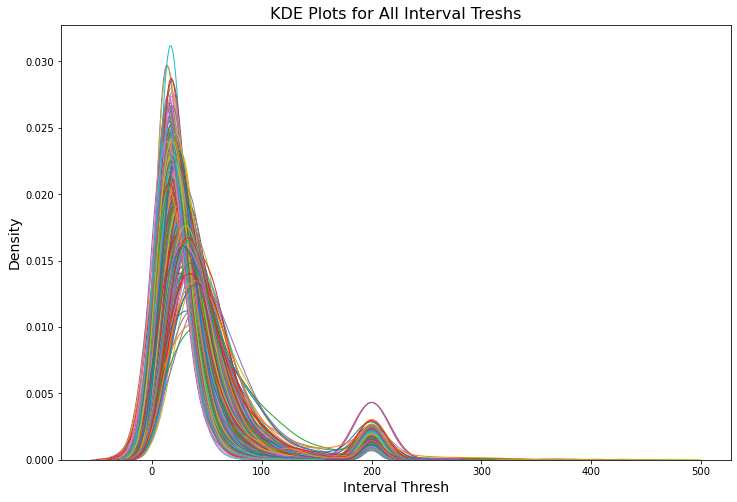

In [93]:

# Assuming the `intervals` DataFrame is already created from previous steps

plt.figure(figsize=(12, 8))

# Loop through each unique combination of Participant, Session, and FileIndex
grouped_intervals = intervals.groupby(['Participant', 'Session', 'FileIndex'])

for (participant, session, file_index), group in grouped_intervals:
    sns.kdeplot(group['thresh'].dropna(), label=f'P{participant}_S{session}_F{file_index}', linewidth=1)
    
# Add labels and title
plt.xlabel('Interval Thresh', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('KDE Plots for All Interval Treshs', fontsize=16)



# Save the figure
savepath = os.path.join(data_savepath_plots, 'all_intervals_thresh_individual.png')
plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


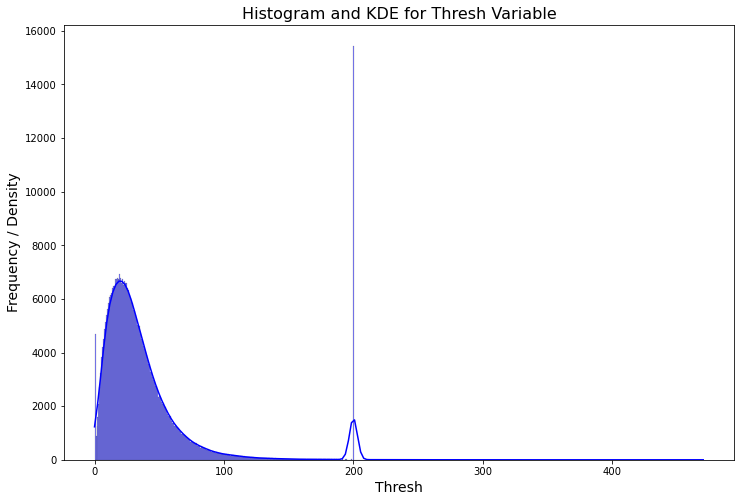

In [94]:
# Extract the 'thresh' values from intervals DataFrame
thresh_values = intervals['thresh'].dropna()

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
sns.histplot(thresh_values, kde=True, color='blue')

# Add labels and title
plt.xlabel('Thresh', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram and KDE for Thresh Variable', fontsize=16)

# Save the figure
savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [95]:
print(np.max(intervals['thresh']))

larger200 = intervals['thresh']> 200
print(sum(larger200))
print(sum(larger200)/len(larger200))

470.31466586311166
401
0.0010141910877642017
